# assignment_1a question 1

# Table of Contents <a name="toc"></a>

* [Imports](#imports)
* [Global](#global)
* [Helper Functions](#helper_functions)
* [Question 1: Convergence](#convergence)
    * [Model Parameters](#model_parameters)
    * [Create the Model](#create_the_model)
    * [Run the Model](#run_the_model)
    * [Save and Load Data Objects](#save_and_load_data_objects)
    * [Plot Model Performance](#plot_model_performance)
    * [Comparing Models](#comparing_models)
    * [Eyeballing Convergence](#eyeballing_convergence)
    * [Try Test Set](#try_test_set)
* [Conclusion](#conclusion)

# Imports <a name="imports"></a> 
[Back to top](#toc)

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json

from tensorflow import keras
from tqdm.keras import TqdmCallback
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [4]:
X_train = np.load('data/X_train.npy')
X_test = np.load('data/X_test.npy')
Y_train = np.load('data/Y_train.npy')
Y_test = np.load('data/Y_test.npy')
print("Data loaded")

Data loaded


# Global <a name="global"></a> 
[Back to top](#toc)

In [5]:
seed = 10
np.random.seed(seed)
tf.random.set_seed(seed)

# data objects
histories = {}

# Helper Functions <a name="helper_functions"></a> 
[Back to top](#toc)

### histories_saver()

In [6]:
# filename like 'data/q0_histories.json'
def histories_saver(histories, filename, already_json=False):
    histories_json = {}
    
    if already_json:
        histories_json = histories
    else:
        for key in histories.keys():
            histories_json[key] = histories[key].history

    with open(filename, 'w') as file:
        json.dump(histories_json, file)

    print("Histories saved")

### histories_loader()

In [7]:
# filename like 'data/q0_histories.json'
def histories_loader(filename):
    with open(filename) as json_file:
        histories = json.load(json_file)
    print('Histories loaded')
    
    return histories 

### plot_history_object()

In [8]:
def plot_history_object(histories, model_name, history_object, plot_val=True):    
    plt.plot(histories[model_name][history_object], label='train_'+history_object)
    
    if plot_val:
        plt.plot(histories[model_name]['val_'+history_object], label='val_'+history_object)
    
    plt.title(history_object + ' against epochs')
    plt.ylabel(history_object)
    plt.xlabel('epochs')
    plt.legend()
    plt.show()

### TestCallback()

In [9]:
# custom callback to evaluate the test set at each epoch
class TestCallback(keras.callbacks.Callback):
    def __init__(self, X_test, Y_test):
        self.X_test = X_test
        self.Y_test = Y_test

    def on_epoch_end(self, epoch, logs={}):
        loss, accuracy, sparse_categorical_crossentropy = self.model.evaluate(self.X_test, self.Y_test, verbose=0)
        
        histories_test['test_values']['accuracy'].append(accuracy)
        histories_test['test_values']['loss'].append(loss)
        histories_test['test_values']['sparse_categorical_crossentropy'].append(sparse_categorical_crossentropy)

# Question 1: Convergence  <a name="convergence"></a>
[Back to top](#toc)

<i>Design a feedforward neural network which consists of an input layer, one hidden layer of 10 neurons with ReLU activation function, and an output softmax layer. Assume a learning rate 𝛼 = 0.01, L2 regularization with weight decay parameter 𝛽 = 10−6, and batch size = 32. Use appropriate scaling of input features.

* a) Use the training dataset to train the model and plot accuracies on training and testing data against training epochs.
* b) State the approximate number of epochs where the test error begin to converge.</i>

### Model Parameters <a name="model_parameters"></a> 
[Back to top](#toc)

Loss function of choice is ```keras.losses.SparseCategoricalCrossentropy(from_logits=False)```

This loss function is defined as being <i>categorical crossentropy with integer targets</i>, which is what we are doing since the output is integer class label. We set ```from_logits=False``` since we have a softmax layer as the output layer

In [10]:
num_neurons = 10
num_classes = 3

weight_decay_parameter = 10e-6
regularization = keras.regularizers.l2(weight_decay_parameter)

learning_rate= 0.01
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metrics = ['accuracy', keras.metrics.SparseCategoricalCrossentropy(from_logits=False)]

validation_split = 0.3
epochs = 1000
batch_size = 32

print("Model Parameters set")

Model Parameters set


To note: the model will report several metrics

1. ```accuracy```
2. ```loss```, which is the regularized loss
3. ```sparse_categorical_crossentropy```, or ```ce```, the loss function without the regularization penalty 

### Create the model <a name="create_the_model"></a> 
[Back to top](#toc)

In [11]:
def create_model(num_neurons, num_classes, regularization, optimizer, loss, metrics):
    model = keras.Sequential([
        keras.layers.Dense(num_neurons, activation='relu', kernel_regularizer=regularization),
        keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)
    
    print("Model created")
    return model

In [12]:
def fit_model(X_train, Y_train, model_name, model, validation_split, epochs, batch_size, callbacks):
    print("Training ", model_name)
    
    history = model.fit(X_train, Y_train,
                            validation_split=validation_split,
                            epochs=epochs,
                            batch_size=batch_size,  
                            callbacks=callbacks,
                            verbose = 0)    
                            
    return model, history

### Run the model <a name="run_the_model"></a> 
[Back to top](#toc)

In [13]:
model = create_model(num_neurons, num_classes, regularization, optimizer, loss, metrics)

# create a new name and callback for every run
model_name = 'convergence_train'
callbacks = [TqdmCallback(verbose=1)]
        
model_convergence_train, histories[model_name] = fit_model(X_train, Y_train, model_name, model, validation_split, epochs, batch_size, callbacks)

Model created


Training  convergence_train



### Save and Load Data Objects <a name="save_and_load_data_objects"></a> 
[Back to top](#toc)

In [14]:
histories_saver(histories, "data/q1_histories.json")

histories = histories_loader("data/q1_histories.json")

Histories saved
Histories loaded


### Plot Model Performance <a name="plot_model_performance"></a> 
[Back to top](#toc)

Model:  convergence_train


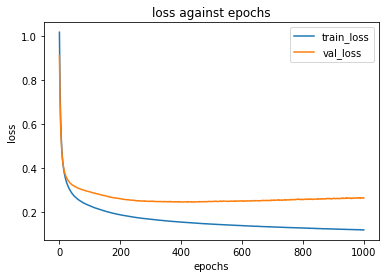

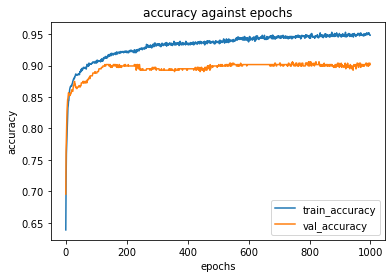

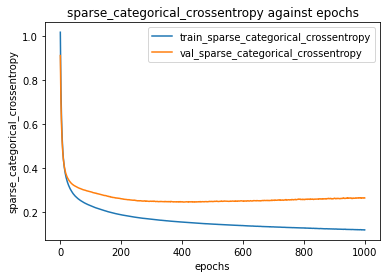

In [15]:
for model_name in histories.keys():
    print('Model: ', model_name)
    for history_object in ['loss', 'accuracy', 'sparse_categorical_crossentropy']:
        plot_history_object(histories, model_name, history_object)

### Eyeballing Convergence <a name="eyeballing_convergence"></a> 
[Back to top](#toc)

We can see that the validation loss for both ```loss``` and ```ce``` has a minimum value. We will use that to estimate the number of epochs necessary to achieve convergence. 

In [16]:
val_loss = histories['convergence_train']['val_loss']
print("val_loss convergence epoch: ", val_loss.index(min(val_loss)))

val_ce = histories['convergence_train']['val_sparse_categorical_crossentropy']
print("val_ce convergence epoch: ", val_ce.index(min(val_ce)))

val_loss convergence epoch:  405
val_ce convergence epoch:  405


> 450 epochs should be a sufficient amount to achieve convergence for the models

### Try Test Set <a name="try_test_set"></a> 
[Back to top](#toc)

We shall train another model with ```epochs=450``` to check the performance of the model on the test set

In [34]:
def train_set_histories_objects(): 
    # the history object to keep performance of X_test Y_test from final model
    histories_test = {
        'test_values': {
            'loss': [],
            'accuracy': [],
            'sparse_categorical_crossentropy': []
        }
    }

    # the history object to keep performance of X_train Y_train from final model
    histories_model = {}
    
    return histories_test, histories_model

In [35]:
def train_set_histories_objects_save(histories_test, histories_model, histories_model_filename):
    histories_saver(histories_model, histories_model_filename)
    histories_model = histories_loader(histories_model_filename)

    histories_model['test_values'] = histories_test['test_values']

    histories_saver(histories_model, histories_model_filename, already_json=True)
    histories_model = histories_loader(histories_model_filename)
    
    return histories_model

In [36]:
histories_final = {}

In [37]:
# the parameter to be changed for the model
epochs = 450

model = create_model(num_neurons, num_classes, regularization, optimizer, loss, metrics)
histories_test, histories_model = train_set_histories_objects()


# create a new name and callback for every run
model_name = 'convergence_test'
callbacks = [TqdmCallback(verbose=1), TestCallback(X_test, Y_test)]
histories_model_filename = "data/q1_histories_model_convergence_test.json"

model_convergence_test, histories_model['train_values'] = fit_model(X_train, Y_train, model_name, model, validation_split, epochs, batch_size, callbacks)


# save it and assign to histories_final
histories_final[model_name] = train_set_histories_objects_save(histories_test, histories_model, histories_model_filename)

Model created


Training  convergence_test

Histories saved
Histories loaded
Histories saved
Histories loaded


> ### a) Use the training dataset to train the model and plot accuracies on training and testing data against training epochs.

##### Save all histories in one object 

In [38]:
histories_saver(histories_final, "data/q1_histories_final.json", already_json=True)
histories_final = histories_loader("data/q1_histories_final.json")

Histories saved
Histories loaded


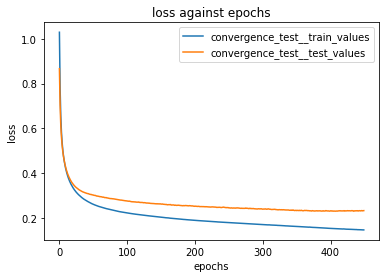

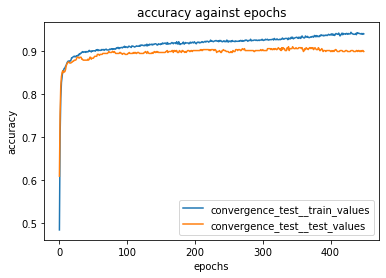

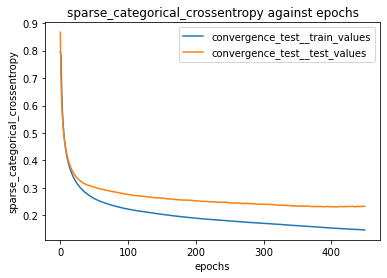

In [39]:
for history_object in ['loss', 'accuracy', 'sparse_categorical_crossentropy']:
    for model_name in histories_final.keys():
        for value_type in histories_final[model_name].keys():
            plt.plot(histories_final[model_name][value_type][history_object], label=model_name + '__' + value_type)

    plt.title(history_object + ' against epochs')
    plt.ylabel(history_object)
    plt.xlabel('epochs')
    plt.legend()
    plt.show()

# Conclusion <a name="conclusion"></a> 
[Back to top](#toc)

> ### b) State the approximate number of epochs where the test error begin to converge

> 450 epochs appears to be more than sufficient to get a reasonable convergence 

We see that using the epoch estimation from train-val split, the train-test set also manages to converge